<a href="https://colab.research.google.com/github/UTMIST/2022-2023-Projects-Workshop/blob/main/Workshop_1_Student_Handout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workshop Student Handout: Facial Expression Recognition with PyTorch**

# 1. Dataset

[See full dataset on Kaggle](https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset)

Before starting on training and designing model architecture, we would need to analyse and **process** the kaggle dataset.  

See a tree diagram for the folder hierachy of the dataset:
 
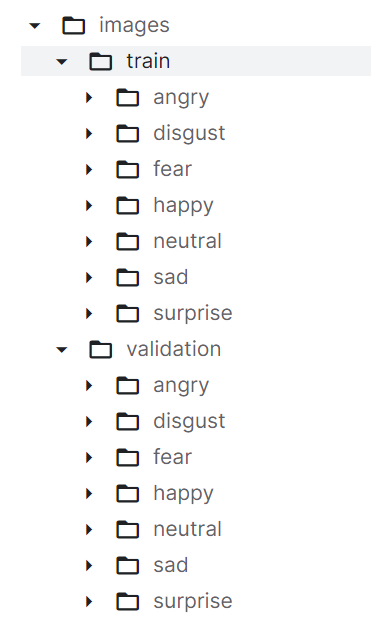

See sample image data below, each image is a gray-scale image with resolution of 48 pixels*48 pixels 

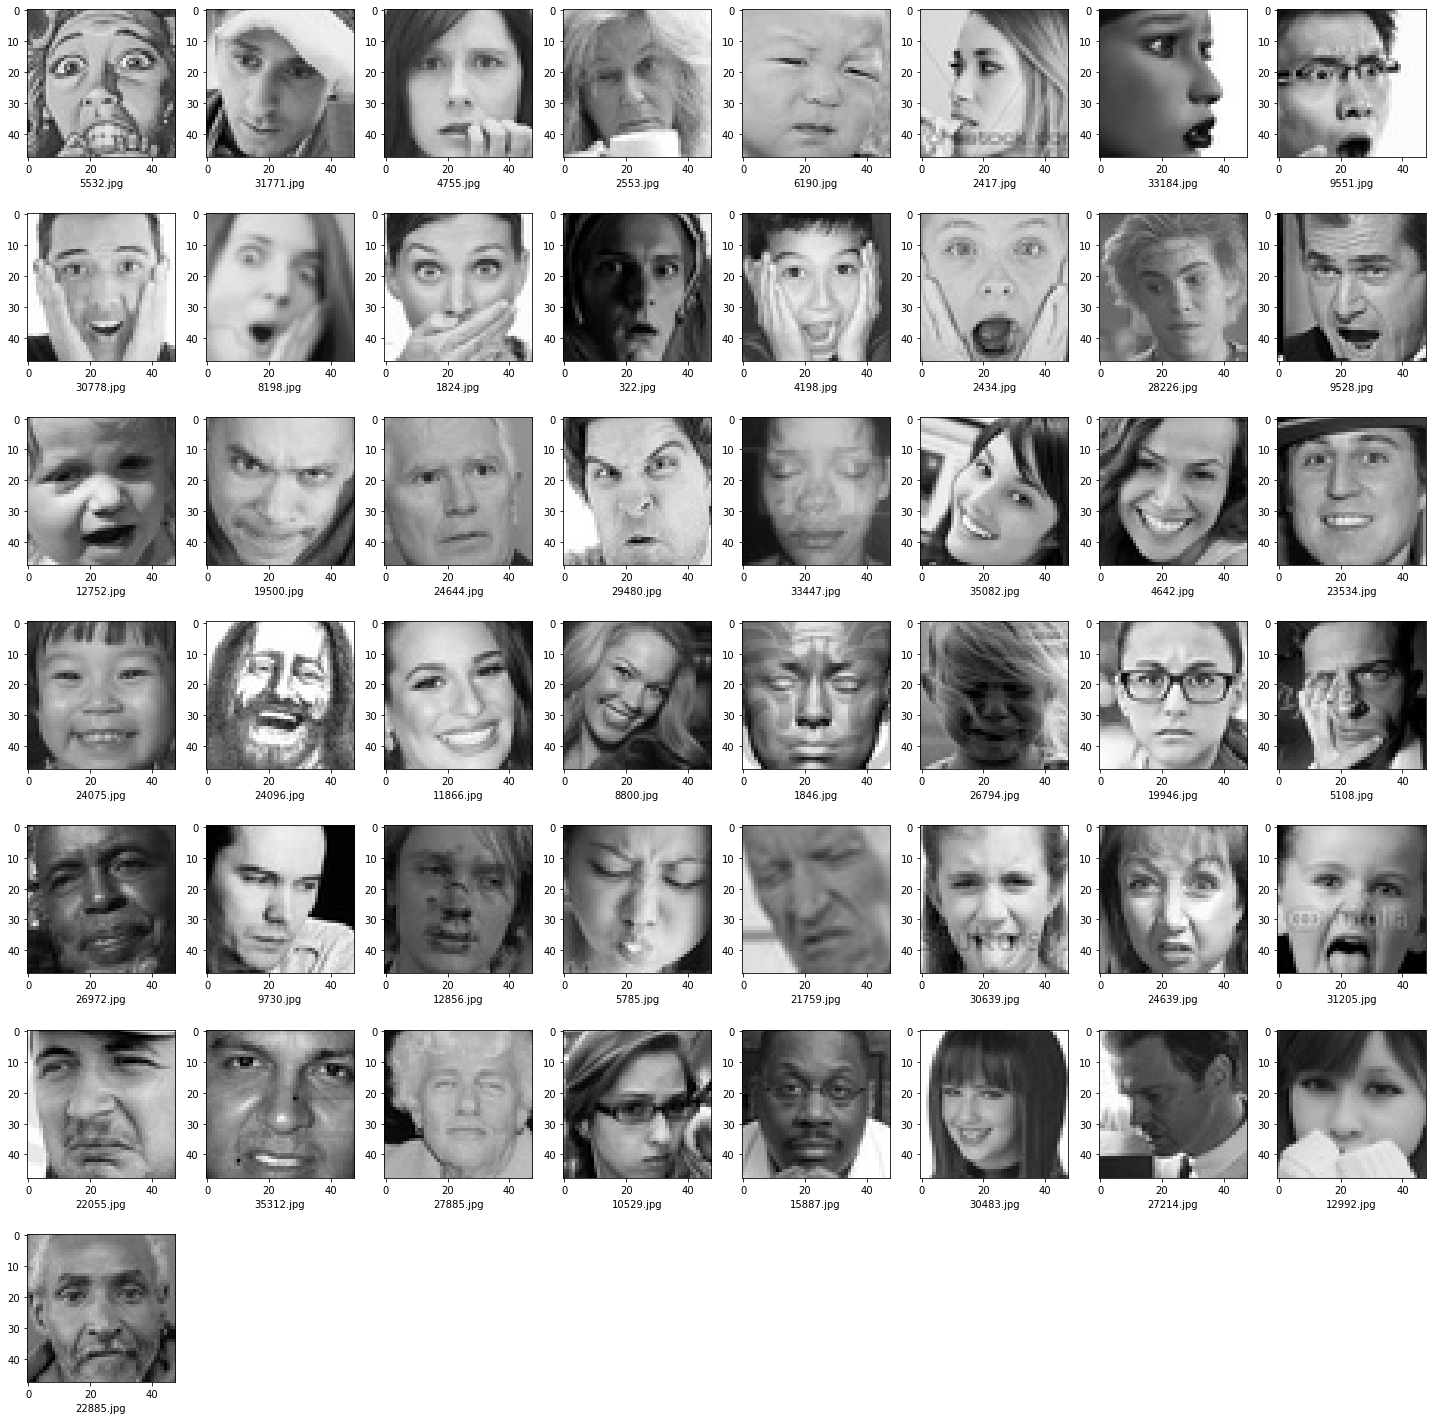

#2. Install libraries, packages and dataset

In [ ]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Import the necessary libraries here: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import os

from torchvision.datasets import ImageFolder
from torchvision import transforms as T

# Configurations

Complete data loading as well as data augumentation

In [ ]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation'

In [ ]:
# data augumentation here
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-20, 20)),
    T.ToTensor() # (h, w, c) -> (c, h, w)
])

valid_augs = T.Compose([
    T.ToTensor()
])

Total no of examples in trainset: 28821
Total no of examples in validset: 7066


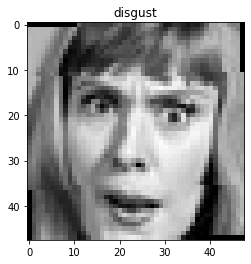

In [ ]:
# use ImageFolder to create trainset and validset
# don't forget to verify it (by visualizing it :))!

trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform=train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform=valid_augs)

print(f"Total no of examples in trainset: {len(trainset)}")
print(f"Total no of examples in validset: {len(validset)}")

def print_random_img(trainset):
  random.seed(100)
  rand_idx = random.random() # between 0 and 1, for example 0.25
  image, label = trainset[int(rand_idx * len(trainset))]  # 28821 * 0.25 = 7205
  plt.imshow(image.permute(1, 2, 0))
  for idx, emotion in enumerate(trainset.class_to_idx.keys()):
    if idx == label:
      label = emotion

  plt.title(label)
  plt.show()

print_random_img(trainset)





In [ ]:
DEVICE='cuda'
MODEL_NAME='efficientnet_b0'

# training hyperparameters (learning rate, batch size, epoches...)
LR = 0.001
BATCH_SIZE = 32
EPOCHS = 50


# Load datasets into loaders for Pytorch training
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

#visulaizing one batch
for images, labels in trainloader:
  break

print(f"One image batch shape: {images.shape}")
print(f"One label batch shape: {labels.shape}")


One image batch shape: torch.Size([32, 3, 48, 48])
One label batch shape: torch.Size([32])


# Create Model 

In [ ]:
#create models
import timm
from torch import nn

class FaceModel(nn.Module):

  def __init__(self):
    super(FaceModel, self).__init__()

    self.eff_net = timm.create_model(MODEL_NAME, pretrained=True, num_classes=7)

  def forward(self, image, labels=None): 
    logits = self.eff_net(image)

    if labels is not None:
      loss = nn.CrossEntropyLoss()(logits, labels)
      return logits, loss

    return logits

In [ ]:
# define model usage (and use cuda - optional!)

model = FaceModel()
model.to(DEVICE)

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 

# Create Train and Eval Function 

In [ ]:
from tqdm import tqdm # for cool progress bar visualization in colab :)

In [ ]:
def multiclass_accuracy(y_pred, y_true):
  top_p, top_class = y_pred.topk(1,dim=1)
  equals = top_class == y_true.view(*top_class.shape)
  return torch.mean(equals.type(torch.FloatTensor))

def train_fn(model, dataloader, optimizer, current_epo):
  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = 'EPOCH' + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': '%6f' %float(total_loss/(t+1)), 'acc': '%6f' %float(total_acc / (t+1))})

  return total_loss / len(dataloader), total_acc / len(dataloader)




In [ ]:
def eval_fn(model, dataloader, current_epo):
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = 'EPOCH' + "[VALID]" + str(current_epo + 1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits, loss = model(images, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': '%6f' %float(total_loss/(t+1)), 'acc': '%6f' %float(total_acc / (t+1))})

  return total_loss / len(dataloader), total_acc / len(dataloader)

# Create Training Loop

In [ ]:
# Create the training loop
# remember to save the best weights

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_fn(model, validloader, i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_weights.pt")
    print("Saved best weights")
    best_valid_loss = valid_loss

EPOCH[VALID]1/50: 100%|██████████| 221/221 [00:05<00:00, 37.19it/s, loss=1.366477, acc=0.481509]


Saved best weights


EPOCH[VALID]2/50: 100%|██████████| 221/221 [00:05<00:00, 37.21it/s, loss=1.191394, acc=0.543661]


Saved best weights


EPOCH[VALID]3/50: 100%|██████████| 221/221 [00:05<00:00, 37.51it/s, loss=1.105285, acc=0.582144]


Saved best weights


EPOCH[VALID]4/50: 100%|██████████| 221/221 [00:05<00:00, 37.49it/s, loss=1.083863, acc=0.594055]


Saved best weights


EPOCH[VALID]5/50: 100%|██████████| 221/221 [00:05<00:00, 37.45it/s, loss=1.070545, acc=0.600657]


Saved best weights


EPOCH[VALID]6/50: 100%|██████████| 221/221 [00:05<00:00, 37.16it/s, loss=1.057213, acc=0.603616]


Saved best weights


EPOCH[VALID]7/50: 100%|██████████| 221/221 [00:05<00:00, 37.54it/s, loss=1.025685, acc=0.612894]


Saved best weights


EPOCH[VALID]8/50: 100%|██████████| 221/221 [00:05<00:00, 37.81it/s, loss=1.024539, acc=0.613677]


Saved best weights


EPOCH[VALID]10/50: 100%|██████████| 221/221 [00:05<00:00, 37.50it/s, loss=1.007149, acc=0.626686]


Saved best weights


EPOCH[VALID]11/50: 100%|██████████| 221/221 [00:05<00:00, 37.23it/s, loss=0.986882, acc=0.631167]


Saved best weights


EPOCH[VALID]13/50: 100%|██████████| 221/221 [00:05<00:00, 37.36it/s, loss=0.974391, acc=0.638879]


Saved best weights


EPOCH[VALID]14/50: 100%|██████████| 221/221 [00:05<00:00, 36.91it/s, loss=0.969908, acc=0.648701]


Saved best weights


EPOCH[VALID]50/50: 100%|██████████| 221/221 [00:06<00:00, 36.55it/s, loss=1.460458, acc=0.639826]


# **HOMEWORK: How to find out the test accuracy of the model?**

tip: use your saved best weights!

# Inference

In [ ]:
def view_classify(img, ps):
    
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)
   
    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None